In [12]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

import bilby
import pycbc
import pickle
import deepdish
import pycbc.psd
import pycbc.types
import gwpopulation
import pycbc.waveform 
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import lalsimulation

import pycbc.waveform as waveform
from pycbc.waveform.utils import taper_timeseries

# import sys
# sys.path.append("../../../gwmat/pnt_Ff_lookup_table/src/cythonized_pnt_lens_class")   
# import cythonized_pnt_lens_class as gwmat.cythonized_point_lens 

In [13]:
def new_rcParams(width='column'):
    
    scale_factor = 2.125

    if width == 'column':
        fig_width_pt = scale_factor*246.0
        fs = scale_factor*7.96
        aspect_ratio=(1 + 5 ** 0.5) / 2
    elif width == 'page':
        fig_width_pt = scale_factor*510.0
        fs = scale_factor*9
        aspect_ratio=2.75
    inches_per_pt = 1.0/72.27

    fig_width = fig_width_pt*inches_per_pt
    fig_height = fig_width/aspect_ratio

    figsize = (fig_width, fig_height)

    new_params = {}
    new_params['figure.figsize'] = figsize
    new_params['font.size'] = fs
    new_params['text.usetex'] = True
    new_params['text.latex.preamble'] = r'\usepackage{amsmath}\usepackage{amssymb}'
    new_params['axes.labelsize'] = 'medium'
    new_params['font.family'] = 'serif'
    new_params['font.serif'] = 'times'
    new_params['mathtext.fontset'] = 'stix'
    new_params['xtick.direction'] = 'in'
    new_params['ytick.direction'] = 'in'
    new_params['xtick.minor.visible'] = True
    new_params['ytick.minor.visible'] = True
    new_params['legend.fontsize'] = 'medium'
    new_params['legend.handlelength'] = 1.5
    
    return new_params

color_palette = {
    'primary': '#0072B2',
    'secondary':  '#CC79A7',
    'tertiary': '#009E73',
    'color3'    : '#D55E00',
    'color4'    : '#56B4E9',
    'color5'    : '#40B0A6',
    'color6'    : '#E69F00',
    'color7'    : '#DC3220',
    'LLO': '#3953a4',
    'LHO': '#ed2024',
    'colormap': 'viridis'
}

import matplotlib.pyplot as plt
plt.rcParams.update(new_rcParams())

In [14]:
delta_f = 1
duration = 100
minimum_frequency = 20
reference_frequency = 50   # Most sensitive frequency
maximum_frequency = 1024
sampling_frequency = 2048
delta_t = 1/sampling_frequency

### Population

In [15]:
injection = deepdish.io.load('../../src/output/injections/injections.hdf5')['injections']

for key, val in injection.items():   # Setting the variables
    exec(key + '=val')

data = np.loadtxt('../../src/output/injections/snr.csv', delimiter=',')
det_idx, snr_det = data[:,0], data[:,1]

num_points = int(len(det_idx) / 2)
idxs = np.random.choice(len(det_idx), size=(num_points, 2), replace=False)

unique_idxs, counts = np.unique(idxs[:, 0], return_counts=True)
mask = counts == 1
filtered_idxs = idxs[mask]

### Waveforms

In [16]:
idx = np.array([1, 2])

injection_parameters_a = {}
for key, val in injection.items():
    injection_parameters_a[key] = val[idx[0]]   # Updating the variables

injection_parameters_b = {}
for key, val in injection.items():
    injection_parameters_b[key] = val[idx[1]]   # Updating the variables
injection_parameters_b['geocent_time'] += 0.8   # Strong Bias

injection_parameters_b['mass_1_source'] = injection_parameters_a['mass_1_source']
injection_parameters_b['mass_ratio'] = injection_parameters_a['mass_ratio']
injection_parameters_b['luminosity_distance'] = injection_parameters_a['luminosity_distance']*1.2

start_time = injection_parameters_a['geocent_time']-duration+2

In [17]:
def wf_len_mod_start(wf, extra=1, **prms):
    """
    Taken from GWMAT. Function to modify the starting of a WF so that it starts on an integer GPS time (in sec) + add extra length as specified by the user.

    Parameters
    ----------
    wf :  pycbc.types.TimeSeries
        WF whose length is to be modified.
    extra : int, optional
        Extra length to be added in the beginning after making the WF to start from an integer GPS time (in sec). Default = 1.

    Returns
    -------
    pycbc.types.timeseries.TimeSeries
        Modified waveform starting form an integer time.

    """      

    olen = len(wf)   
    diff = wf.sample_times[0]-np.floor(wf.sample_times[0])  
    #nlen = round(olen+sampling_frequency*(extra+diff))
    dlen = round(sampling_frequency*(extra+diff))
    wf_strain = np.concatenate((np.zeros(dlen), wf))
    t0 = wf.sample_times[0]
    dt = wf.delta_t
    n = dlen
    tnn = t0-(n+1)*dt
    wf_stime = np.concatenate((np.arange(t0-dt,tnn,-dt)[::-1], np.array(wf.sample_times)))
    nwf = pycbc.types.TimeSeries(wf_strain, delta_t=wf.delta_t, epoch=wf_stime[0])
    
    return nwf

def wf_len_mod_end(wf, extra=2, **prms): #post_trig_duration
    """
    Taken from GWMAT. Function to modify the end of a WF so that it ends on an integer GPS time (in sec) + add extra length as specified by the user.

    Parameters
    ----------
    wf : pycbc.types.TimeSeries
        WF whose length is to be modified.
    extra : int, optional
        Extra length to be added towards the end after making the WF to end from an integer GPS time (in sec). 
        Default = 2, which makes sure post-trigger duration is of at least 2 seconds.

    Returns
    -------
    pycbc.types.timeseries.TimeSeries
        Modified waveform ending on an integer time.

    """        

    olen = len(wf)   
    dt = abs(wf.sample_times[-1] - wf.sample_times[-2])
    diff = np.ceil(wf.sample_times[-1]) - (wf.sample_times[-1] + dt)   #wf.sample_times[-1]-int(wf.sample_times[-1])  
    nlen = round(olen + sampling_frequency*(extra+diff))
    wf.resize(nlen)
    
    return wf    

def make_len_power_of_2(wf):
    """
    Taken from GWMAT. Function to modify the length of a waveform so that its duration is a power of 2.

    Parameters
    ----------
    wf : pycbc.types.TimeSeries
        WF whose length is to be modified.
        Modified waveform with duration a power of 2.
    Returns
    -------
    pycbc.types.timeseries.TimeSeries
        Returns the waveform with length a power of 2.

    """    

    dur = wf.duration  
    wf.resize( int(round(wf.sample_rate * np.power(2, np.ceil( np.log2( dur ) ) ))) )
    wf = cyclic_time_shift_of_WF(wf, rwrap = wf.duration - dur )
    
    return wf    

def cyclic_time_shift_of_WF(wf, rwrap=0.2):
    """
    Taken from GWMAT. Inspired by PyCBC's function pycbc.types.TimeSeries.cyclic_time_shift(), 
        it shifts the data and timestamps in the time domain by a given number of seconds (rwrap). 
        Difference between this and PyCBCs function is that this function preserves the sample rate of the WFs while cyclically rotating, 
        but the time shift cannot be smaller than the intrinsic sample rate of the data, unlike PyCBc's function.
        To just change the time stamps, do ts.start_time += dt.
        Note that data will be cyclically rotated, so if you shift by 2
        seconds, the final 2 seconds of your data will now be at the
        beginning of the data set.

    Parameters
    ----------
    wf : pycbc.types.TimeSeries
        The waveform for cyclic rotation.
    rwrap : float, optional
        Amount of time to shift the vector. Default = 0.2.

    Returns
    -------
    pycbc.types.TimeSeries
        The time shifted time series.

    """        

    # This function does cyclic time shift of a WF.
    # It is similar to PYCBC's "cyclic_time_shift" except for the fact that it also preserves the Sample Rate of the original WF.
    if rwrap is not None and rwrap != 0:
        sn = abs(int(rwrap/wf.delta_t))     # number of elements to be shifted 
        cycles = int(sn/len(wf))

        cyclic_shifted_wf = wf.copy()

        sn_new = sn - int(cycles * len(wf))

        if rwrap > 0:
            epoch = wf.sample_times[0] - sn_new * wf.delta_t
            if sn_new != 0:
                wf_arr = np.array(wf).copy()
                tmp_wf_p1 = wf_arr[-sn_new:]
                tmp_wf_p2 = wf_arr[:-sn_new] 
                shft_wf_arr = np.concatenate(( tmp_wf_p1, tmp_wf_p2 ))
                cyclic_shifted_wf = pycbc.types.TimeSeries(shft_wf_arr, delta_t = wf.delta_t, epoch = epoch)
        else:
            epoch = wf.sample_times[sn_new]
            if sn_new != 0:
                wf_arr = np.array(wf).copy()
                tmp_wf_p1 = wf_arr[sn_new:] 
                tmp_wf_p2 = wf_arr[:sn_new]
                shft_wf_arr = np.concatenate(( tmp_wf_p1, tmp_wf_p2 ))
                cyclic_shifted_wf = pycbc.types.TimeSeries(shft_wf_arr, delta_t = wf.delta_t, epoch = epoch)  

        for i in range(cycles):        
                epoch = epoch - np.sign(rwrap)*wf.duration
                wf_arr = np.array(cyclic_shifted_wf)[:]
                cyclic_shifted_wf = pycbc.types.TimeSeries(wf_arr, delta_t = wf.delta_t, epoch = epoch)

        assert len(cyclic_shifted_wf) == len(wf), 'Length mismatch: cyclic time shift added extra length to WF.'
        return cyclic_shifted_wf
    else:
        return wf  

def jframe_to_l0frame(mass_1, mass_2, reference_frequency, phi_ref=0., theta_jn=0., phi_jl=0., a_1=0., a_2=0., tilt_1=0., tilt_2=0., phi_12=0., **kwargs):  
    """
    [Inherited from PyCBC and lalsimulation.]
        Function to convert J-frame coordinates (which Bilby uses for PE) to L0-frame coordinates (that Pycbc uses for waveform generation).
        J stands for the total angular momentum while L0 stands for the orbital angular momentum.
    """ 

    inclination, spin1x, spin1y, spin1z, spin2x, spin2y, spin2z = \
        lalsimulation.SimInspiralTransformPrecessingNewInitialConditions(
            theta_jn, phi_jl, tilt_1, tilt_2, phi_12,
            a_1, a_2, mass_1*lal.MSUN_SI, mass_2*lal.MSUN_SI, reference_frequency,
            phi_ref)
    out_dict = {'inclination': inclination,
                'spin1x': spin1x,
                'spin1y': spin1y,
                'spin1z': spin1z,
                'spin2x': spin2x,
                'spin2y': spin2y,
                'spin2z': spin2z}
    return out_dict

lframe_a = jframe_to_l0frame(mass_1=injection_parameters_a['mass_1'], 
                            mass_2=injection_parameters_a['mass_2'], 
                            reference_frequency=reference_frequency, 
                            theta_jn=injection_parameters_a['theta_jn'], 
                            phi_jl=injection_parameters_a['phi_jl'], 
                            a_1=injection_parameters_a['a_1'], 
                            a_2=injection_parameters_a['a_2'], 
                            tilt_1=injection_parameters_a['tilt_1'], 
                            tilt_2=injection_parameters_a['tilt_2'], 
                            phi_12=injection_parameters_a['phi_12'])   

waveform_params_a = {
    'approximant': 'IMRPhenomXPHM',
    'mass1': injection_parameters_a['mass_1'],
    'mass2': injection_parameters_a['mass_2'],
    'spin1x': lframe_a['spin1x'],
    'spin1y': lframe_a['spin1y'],
    'spin1z': lframe_a['spin1z'],
    'spin2x': lframe_a['spin2x'],
    'spin2y': lframe_a['spin2y'],
    'spin2z': lframe_a['spin2z'],
    'distance': injection_parameters_a['luminosity_distance'],
    'inclination': lframe_a['inclination'],
    'coa_phase': injection_parameters_a['phase'],
    'f_lower': minimum_frequency,
    'f_ref': reference_frequency,
    'delta_t': delta_t
}

lframe_b = jframe_to_l0frame(mass_1=injection_parameters_b['mass_1'],
                            mass_2=injection_parameters_b['mass_2'],
                            reference_frequency=reference_frequency,
                            theta_jn=injection_parameters_b['theta_jn'],
                            phi_jl=injection_parameters_b['phi_jl'],
                            a_1=injection_parameters_b['a_1'],
                            a_2=injection_parameters_b['a_2'],
                            tilt_1=injection_parameters_b['tilt_1'],
                            tilt_2=injection_parameters_b['tilt_2'],
                            phi_12=injection_parameters_b['phi_12'])

waveform_params_b = {
    'approximant': 'IMRPhenomXPHM',
    'mass1': injection_parameters_b['mass_1'],
    'mass2': injection_parameters_b['mass_2'],
    'spin1x': lframe_b['spin1x'],
    'spin1y': lframe_b['spin1y'],
    'spin1z': lframe_b['spin1z'],
    'spin2x': lframe_b['spin2x'],
    'spin2y': lframe_b['spin2y'],
    'spin2z': lframe_b['spin2z'],
    'distance': injection_parameters_b['luminosity_distance'],
    'inclination': lframe_b['inclination'],
    'coa_phase': injection_parameters_b['phase'],
    'f_lower': minimum_frequency,
    'f_ref': reference_frequency,
    'delta_t': delta_t
}

In [18]:
det, ifo_signal_a, ifo_signal_b = dict(), dict(), dict()
for ifo in ['H1', 'L1', 'V1']:
    det[ifo] = pycbc.detector.Detector(ifo)

    hp_a, hc_a = waveform.get_td_waveform(**waveform_params_a)
    hp_a.start_time += injection_parameters_a['geocent_time']
    hc_a.start_time += injection_parameters_a['geocent_time']

    ifo_signal_a[ifo] = det[ifo].project_wave(hp_a, hc_a, injection_parameters_a['ra'], injection_parameters_a['dec'], injection_parameters_a['psi'])
    #ifo_signal_a[ifo] = taper_timeseries(ifo_signal_a[ifo], tapermethod='TAPER_STARTEND', return_lal=False)
    #ifo_signal_a[ifo] = make_len_power_of_2(wf_len_mod_end(wf_len_mod_start(ifo_signal_a[ifo])))
    
    hp_b, hc_b = waveform.get_td_waveform(**waveform_params_b)
    hp_b.start_time += injection_parameters_b['geocent_time']
    hc_b.start_time += injection_parameters_b['geocent_time']

    ifo_signal_b[ifo] = det[ifo].project_wave(hp_b, hc_b, injection_parameters_b['ra'], injection_parameters_b['dec'], injection_parameters_b['psi'])
    #ifo_signal_b[ifo] = taper_timeseries(ifo_signal_b[ifo], tapermethod='TAPER_STARTEND', return_lal=False)
    #ifo_signal_b[ifo] = make_len_power_of_2(wf_len_mod_end(wf_len_mod_start(ifo_signal_b[ifo])))

ht_H1_a, ht_L1_a, ht_V1_a = ifo_signal_a['H1'], ifo_signal_a['L1'], ifo_signal_a['V1']
ht_H1_b, ht_L1_b, ht_V1_b = ifo_signal_b['H1'], ifo_signal_b['L1'], ifo_signal_b['V1']
ht_a, ht_b = {'H1': ht_H1_a, 'L1': ht_L1_a, 'V1': ht_V1_a}, {'H1': ht_H1_b, 'L1': ht_L1_b, 'V1': ht_V1_b}

delta_f = np.min([ht_H1_a.delta_f, ht_L1_a.delta_f, ht_V1_a.delta_f, ht_H1_b.delta_f, ht_L1_b.delta_f, ht_V1_b.delta_f])
hf_a_H1, hf_a_L1, hf_a_V1 = ht_H1_a.to_frequencyseries(delta_f=delta_f), ht_L1_a.to_frequencyseries(delta_f=delta_f), ht_V1_a.to_frequencyseries(delta_f=delta_f)
hf_b_H1, hf_b_L1, hf_b_V1 = ht_H1_b.to_frequencyseries(delta_f=delta_f), ht_L1_b.to_frequencyseries(delta_f=delta_f), ht_V1_b.to_frequencyseries(delta_f=delta_f)

hf_H1 = hf_a_H1 + hf_b_H1 * np.exp(-1j * 2 * np.pi * (hf_b_H1.epoch.gpsSeconds + hf_b_H1.epoch.gpsNanoSeconds * 1e-9 - hf_a_H1.epoch.gpsSeconds - hf_a_H1.epoch.gpsNanoSeconds * 1e-9) * hf_b_H1.sample_frequencies)
hf_L1 = hf_a_L1 + hf_b_L1 * np.exp(-1j * 2 * np.pi * (hf_b_L1.epoch.gpsSeconds + hf_b_L1.epoch.gpsNanoSeconds * 1e-9 - hf_a_L1.epoch.gpsSeconds - hf_a_L1.epoch.gpsNanoSeconds * 1e-9) * hf_b_L1.sample_frequencies)
hf_V1 = hf_a_V1 + hf_b_V1 * np.exp(-1j * 2 * np.pi * (hf_b_V1.epoch.gpsSeconds + hf_b_V1.epoch.gpsNanoSeconds * 1e-9 - hf_a_V1.epoch.gpsSeconds - hf_a_V1.epoch.gpsNanoSeconds * 1e-9) * hf_b_V1.sample_frequencies)

ht_H1, ht_L1, ht_V1 = hf_H1.to_timeseries(), hf_L1.to_timeseries(), hf_V1.to_timeseries()
ht = {'H1': ht_H1, 'L1': ht_L1, 'V1': ht_V1}

In [19]:
# Bilby's WaveformGenerator object to generate BBH waveforms

waveform_generator_a = bilby.gw.WaveformGenerator(duration = duration, sampling_frequency = sampling_frequency, start_time = start_time,
                                                  frequency_domain_source_model = bilby.gw.source.lal_binary_black_hole, 
                                                  waveform_arguments = {'waveform_approximant': 'IMRPhenomPv2', 'reference_frequency': reference_frequency, 'minimum_frequency': minimum_frequency})

waveform_generator_b = bilby.gw.WaveformGenerator(duration=duration, sampling_frequency = sampling_frequency, start_time = start_time,
                                                  frequency_domain_source_model = bilby.gw.source.lal_binary_black_hole, 
                                                  waveform_arguments = {'waveform_approximant': 'IMRPhenomPv2', 'reference_frequency': reference_frequency, 'minimum_frequency': minimum_frequency})

# Initializing the detectors as bilby interferometer objects with zero noise, and with GPS time around the geocenter time of the GW signal

ifos, ifos_a, ifos_b = bilby.gw.detector.InterferometerList(['H1', 'L1', 'V1']), bilby.gw.detector.InterferometerList(['H1', 'L1', 'V1']), bilby.gw.detector.InterferometerList(['H1', 'L1', 'V1'])   # Initialize Detectors
for det in [ifos, ifos_a, ifos_b]:
    for ifo in det:
        ifo.minimum_frequency, ifo.maximum_frequency  = minimum_frequency, sampling_frequency/2
    det.set_strain_data_from_zero_noise(sampling_frequency = sampling_frequency, duration = duration, start_time = start_time)

# Injecting the SINGLES GW signal into H1, L1, and V1 using bilby, and saving the parameters

ifos_a.inject_signal(waveform_generator = waveform_generator_a, parameters = injection_parameters_a)    # SINGLES A
with open('../../src/output/injections/Waveform A Meta Data.pkl', 'wb') as file:
    pickle.dump(ifos_a.meta_data, file) 

ifos_b.inject_signal(waveform_generator = waveform_generator_b, parameters = injection_parameters_b)    # SINGLES B
with open('../../src/output/injections/Waveform B Meta Data.pkl', 'wb') as file:
    pickle.dump(ifos_b.meta_data, file)

ifos.inject_signal(waveform_generator = waveform_generator_a, parameters = injection_parameters_a)    # PAIRS (A)
ifos.inject_signal(waveform_generator = waveform_generator_b, parameters = injection_parameters_b)    # PAIRS (B)

# Extrapolating the strain data in the time domain

H1_strain_a, L1_strain_a, V1_strain_a = ifos_a[0].time_domain_strain, ifos_a[1].time_domain_strain, ifos_a[2].time_domain_strain    # SINGLES A
H1_strain_b, L1_strain_b, V1_strain_b = ifos_b[0].time_domain_strain, ifos_b[1].time_domain_strain, ifos_b[2].time_domain_strain    # SINGLES B
H1_strain, L1_strain, V1_strain = ifos[0].time_domain_strain, ifos[1].time_domain_strain, ifos[2].time_domain_strain    # PAIRS

# Generating PyCBC TimeSeries from the strain array

ht_a_H1, ht_a_L1, ht_a_V1 = pycbc.types.TimeSeries(H1_strain_a, delta_t = 1/sampling_frequency), pycbc.types.TimeSeries(L1_strain_a, delta_t = 1/sampling_frequency), pycbc.types.TimeSeries(V1_strain_a, delta_t = 1/sampling_frequency)    # SINGLES A
ht_b_H1, ht_b_L1, ht_b_V1 = pycbc.types.TimeSeries(H1_strain_b, delta_t = 1/sampling_frequency), pycbc.types.TimeSeries(L1_strain_b, delta_t = 1/sampling_frequency), pycbc.types.TimeSeries(V1_strain_b, delta_t = 1/sampling_frequency)    # SINGLES B
ht_H1, ht_L1, ht_V1 = pycbc.types.TimeSeries(H1_strain, delta_t = 1/sampling_frequency), pycbc.types.TimeSeries(L1_strain, delta_t = 1/sampling_frequency), pycbc.types.TimeSeries(V1_strain, delta_t = 1/sampling_frequency)    # PAIRS

# Setting the start times to the geocenter time and creating the dictionary of waveforms 

ht_a_H1.start_time, ht_a_L1.start_time, ht_a_V1.start_time = start_time, start_time, start_time    # SINGLES A
ht_b_H1.start_time, ht_b_L1.start_time, ht_b_V1.start_time = start_time, start_time, start_time    # SINGLES B
ht_H1.start_time, ht_L1.start_time, ht_V1.start_time = start_time, start_time, start_time    # PAIRS

ht_a, ht_b, ht = {'H1': ht_a_H1, 'L1': ht_a_L1, 'V1': ht_a_V1}, {'H1': ht_b_H1, 'L1': ht_b_L1, 'V1': ht_b_V1}, {'H1': ht_H1, 'L1': ht_L1, 'V1': ht_V1}

16:03 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
16:03 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
16:03 bilby INFO    : Injected signal in H1:
16:03 bilby INFO    :   optimal SNR = 3.36
16:03 bilby INFO    :   matched filter SNR = 3.36-0.00j
16:03 bilby INFO    :   mass_1_source = 9.692722415709435
16:03 bilby INFO    :   mass_ratio = 0.505011330319816
16:03 bilby INFO    :   a_1 = 0.02682380001104811
16:03 bilby INFO    :   a_2 = 0.47828457514977235
16:03 bilby INFO    :   redshift = 1.5031143901957655
16:03 bilby INFO    :   cos_tilt_1 = 0.0029793275311491914
16:03 bilby INFO    :   cos_tilt_2

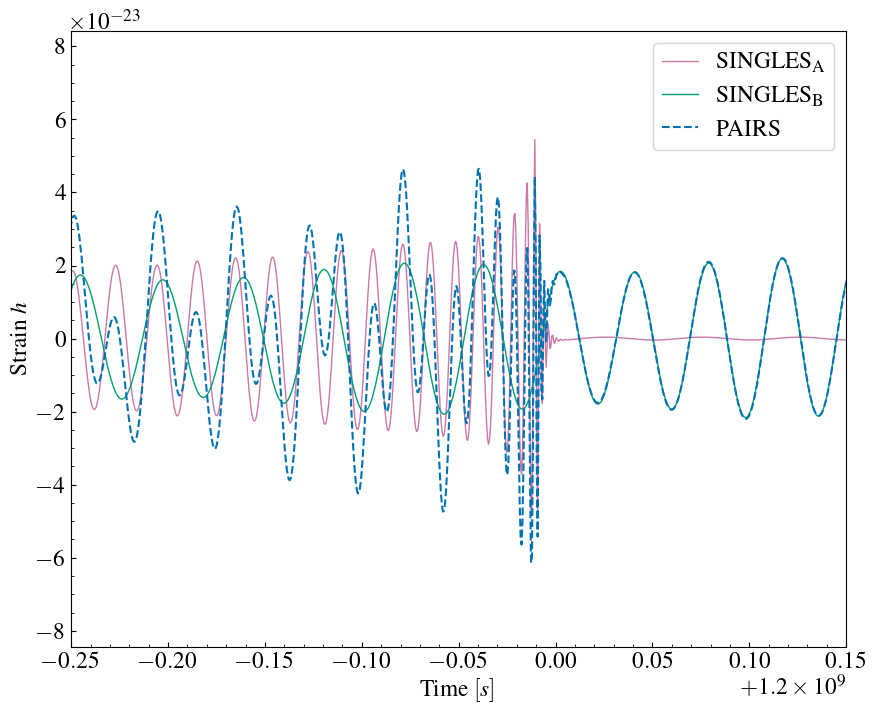

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(ht_a['H1'].sample_times, ht_a['H1'], color=color_palette['secondary'], linewidth=1, label='$\\rm{SINGLES_A}$')
ax.plot(ht_b['H1'].sample_times, ht_b['H1'], color=color_palette['tertiary'], linewidth=1, label='$\\rm{SINGLES_B}$')
ax.plot(ht['H1'].sample_times, ht['H1'], '--', color=color_palette['primary'], label='$\\rm{PAIRS}$')
ax.set_xlabel('Time $[s]$')
ax.set_ylabel('Strain $h$')
ax.set_xlim(start_time+duration-2.25, start_time+duration-1.85)
ax.legend()
plt.savefig('../../plots/OverlappedSignals1.pdf', dpi=600, bbox_inches='tight')
plt.show()

In [21]:
idx = np.array([1, 1])

injection_parameters_a = {}
for key, val in injection.items():
    injection_parameters_a[key] = val[idx[0]]   # Updating the variables

injection_parameters_b = {}
for key, val in injection.items():
    injection_parameters_b[key] = val[idx[1]]   # Updating the variables
injection_parameters_b['geocent_time'] += 0.1   # Strong Bias

injection_parameters_b['luminosity_distance'] = injection_parameters_a['luminosity_distance']*.9

start_time = injection_parameters_a['geocent_time']-duration+2

# Bilby's WaveformGenerator object to generate BBH waveforms

waveform_generator_a = bilby.gw.WaveformGenerator(duration = duration, sampling_frequency = sampling_frequency, start_time = start_time,
                                                  frequency_domain_source_model = bilby.gw.source.lal_binary_black_hole, 
                                                  waveform_arguments = {'waveform_approximant': 'IMRPhenomPv2', 'reference_frequency': reference_frequency, 'minimum_frequency': minimum_frequency})

waveform_generator_b = bilby.gw.WaveformGenerator(duration=duration, sampling_frequency = sampling_frequency, start_time = start_time,
                                                  frequency_domain_source_model = bilby.gw.source.lal_binary_black_hole, 
                                                  waveform_arguments = {'waveform_approximant': 'IMRPhenomPv2', 'reference_frequency': reference_frequency, 'minimum_frequency': minimum_frequency})

# Initializing the detectors as bilby interferometer objects with zero noise, and with GPS time around the geocenter time of the GW signal

ifos, ifos_a, ifos_b = bilby.gw.detector.InterferometerList(['H1', 'L1', 'V1']), bilby.gw.detector.InterferometerList(['H1', 'L1', 'V1']), bilby.gw.detector.InterferometerList(['H1', 'L1', 'V1'])   # Initialize Detectors
for det in [ifos, ifos_a, ifos_b]:
    for ifo in det:
        ifo.minimum_frequency, ifo.maximum_frequency  = minimum_frequency, sampling_frequency/2
    det.set_strain_data_from_zero_noise(sampling_frequency = sampling_frequency, duration = duration, start_time = start_time)

# Injecting the SINGLES GW signal into H1, L1, and V1 using bilby, and saving the parameters

ifos_a.inject_signal(waveform_generator = waveform_generator_a, parameters = injection_parameters_a)    # SINGLES A
with open('../../src/output/injections/Waveform A Meta Data.pkl', 'wb') as file:
    pickle.dump(ifos_a.meta_data, file) 

ifos_b.inject_signal(waveform_generator = waveform_generator_b, parameters = injection_parameters_b)    # SINGLES B
with open('../../src/output/injections/Waveform B Meta Data.pkl', 'wb') as file:
    pickle.dump(ifos_b.meta_data, file)

ifos.inject_signal(waveform_generator = waveform_generator_a, parameters = injection_parameters_a)    # PAIRS (A)
ifos.inject_signal(waveform_generator = waveform_generator_b, parameters = injection_parameters_b)    # PAIRS (B)

# Extrapolating the strain data in the time domain

H1_strain_a, L1_strain_a, V1_strain_a = ifos_a[0].time_domain_strain, ifos_a[1].time_domain_strain, ifos_a[2].time_domain_strain    # SINGLES A
H1_strain_b, L1_strain_b, V1_strain_b = ifos_b[0].time_domain_strain, ifos_b[1].time_domain_strain, ifos_b[2].time_domain_strain    # SINGLES B
H1_strain, L1_strain, V1_strain = ifos[0].time_domain_strain, ifos[1].time_domain_strain, ifos[2].time_domain_strain    # PAIRS

# Generating PyCBC TimeSeries from the strain array

ht_a_H1, ht_a_L1, ht_a_V1 = pycbc.types.TimeSeries(H1_strain_a, delta_t = 1/sampling_frequency), pycbc.types.TimeSeries(L1_strain_a, delta_t = 1/sampling_frequency), pycbc.types.TimeSeries(V1_strain_a, delta_t = 1/sampling_frequency)    # SINGLES A
ht_b_H1, ht_b_L1, ht_b_V1 = pycbc.types.TimeSeries(H1_strain_b, delta_t = 1/sampling_frequency), pycbc.types.TimeSeries(L1_strain_b, delta_t = 1/sampling_frequency), pycbc.types.TimeSeries(V1_strain_b, delta_t = 1/sampling_frequency)    # SINGLES B
ht_H1, ht_L1, ht_V1 = pycbc.types.TimeSeries(H1_strain, delta_t = 1/sampling_frequency), pycbc.types.TimeSeries(L1_strain, delta_t = 1/sampling_frequency), pycbc.types.TimeSeries(V1_strain, delta_t = 1/sampling_frequency)    # PAIRS

# Setting the start times to the geocenter time and creating the dictionary of waveforms 

ht_a_H1.start_time, ht_a_L1.start_time, ht_a_V1.start_time = start_time, start_time, start_time    # SINGLES A
ht_b_H1.start_time, ht_b_L1.start_time, ht_b_V1.start_time = start_time, start_time, start_time    # SINGLES B
ht_H1.start_time, ht_L1.start_time, ht_V1.start_time = start_time, start_time, start_time    # PAIRS

ht_a, ht_b, ht = {'H1': ht_a_H1, 'L1': ht_a_L1, 'V1': ht_a_V1}, {'H1': ht_b_H1, 'L1': ht_b_L1, 'V1': ht_b_V1}, {'H1': ht_H1, 'L1': ht_L1, 'V1': ht_V1}

16:03 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
16:03 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
16:03 bilby INFO    : Injected signal in H1:
16:03 bilby INFO    :   optimal SNR = 3.36
16:03 bilby INFO    :   matched filter SNR = 3.36-0.00j
16:03 bilby INFO    :   mass_1_source = 9.692722415709435
16:03 bilby INFO    :   mass_ratio = 0.505011330319816
16:03 bilby INFO    :   a_1 = 0.02682380001104811
16:03 bilby INFO    :   a_2 = 0.47828457514977235
16:03 bilby INFO    :   redshift = 1.5031143901957655
16:03 bilby INFO    :   cos_tilt_1 = 0.0029793275311491914
16:03 bilby INFO    :   cos_tilt_2

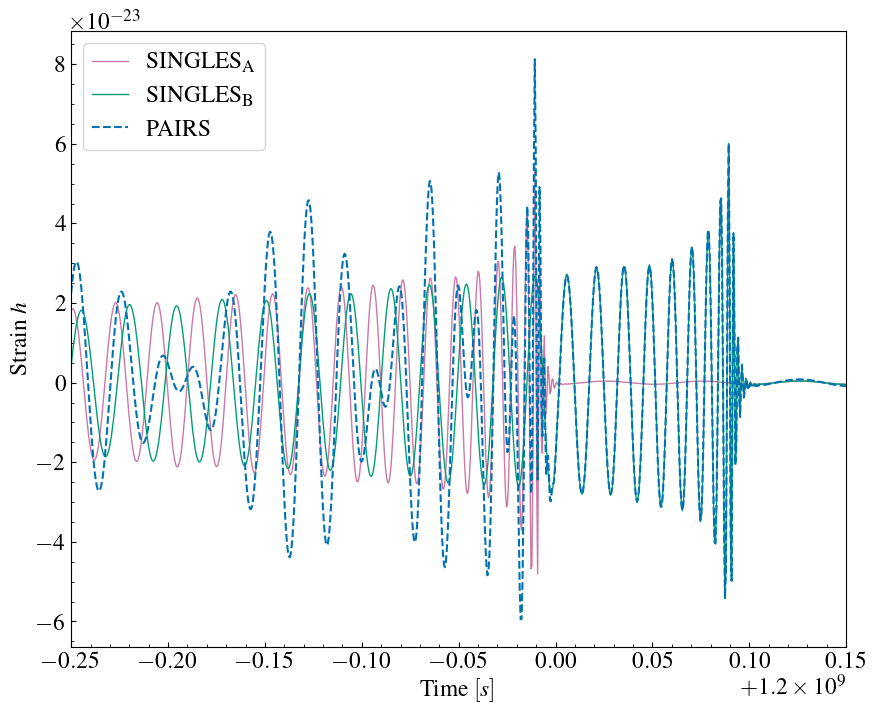

In [22]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(ht_a['H1'].sample_times, ht_a['H1'], color=color_palette['secondary'], linewidth=1, label='$\\rm{SINGLES_A}$')
ax.plot(ht_b['H1'].sample_times, ht_b['H1'], color=color_palette['tertiary'], linewidth=1, label='$\\rm{SINGLES_B}$')
ax.plot(ht['H1'].sample_times, ht['H1'], '--', color=color_palette['primary'], label='$\\rm{PAIRS}$')
ax.set_xlabel('Time $[s]$')
ax.set_ylabel('Strain $h$')
ax.set_xlim(start_time+duration-2.25, start_time+duration-1.85)
ax.legend()
plt.savefig('../../plots/OverlappedSignals2.pdf', dpi=600, bbox_inches='tight')
plt.show()